# ADAM15 
- Isoform (ENST00000271836.10_1) colocalizes with albumin. 
- Variant with PPA = 1 (VAR_1_155033308_G_A: rs11589479) is splice donor (last nucleotide in exon, G>A, disrupts donor site)
- samtools mpileup on all samples: do only samples with alternate allele have reads into the intron?
- samtools view: extract only intron region and check the genotype at the splice donor
- since this is a iPSC-CVPC-associated eQTL, test only iPSC-CVPCs

In [6]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_gwas_coloc")

source("script/functions.R"  )


In [7]:
dir.create("pipeline/eqtl.3.adam15"        , showWarnings = FALSE)
dir.create("pipeline/eqtl.3.adam15/mpileup", showWarnings = FALSE)
dir.create("pipeline/eqtl.3.adam15/view"   , showWarnings = FALSE)


In [8]:
qtl_list = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/qtl/qtls.RDS"   )
exp_list = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/expdata_qtl.rds")

In [9]:
phenotypes            = c("rna", "isoform")
qtls                  = qtl_list$qtl[phenotypes]
cell_assocs           = as.data.frame(rbindlist(qtl_list$interactions[phenotypes]), stringsAsFactors = FALSE)
coordinates           = exp_list$coordinates
rownames(coordinates) = coordinates$transcript_id
coordinates           = coordinates[ coordinates$phenotype %in% phenotypes,]

In [24]:
id             = "VAR_1_155033308_G_A"
rsid           = "rs11589479"
transcript_id  = "ENST00000271836.10_1"
type           = 0
gene_id        = coordinates[ coordinates$transcript_id == transcript_id & coordinates$phenotype == "isoform", "gene_id"      ]
transcript_ids = coordinates[ coordinates$gene_id       == gene_id       & coordinates$phenotype == "isoform", "transcript_id"]

In [123]:
cell_assocs[ cell_assocs$transcript_id == transcript_id & cell_assocs$type == 0, c("interaction", "cell", "specific", "associated")]

,interaction,cell,specific,associated
,<chr>,<lgl>,<lgl>,<lgl>
289038,arteria,TRUE,FALSE,TRUE
297527,arteria_aorta,TRUE,FALSE,TRUE
306016,arteria_coronary,FALSE,FALSE,FALSE
314505,cibersort.regular.cardiac_muscle,FALSE,FALSE,FALSE
322994,cibersort.regular.cardiac_neuron,TRUE,TRUE,FALSE
331483,cibersort.regular.endocardial,TRUE,FALSE,TRUE
339972,cibersort.regular.endothelial,FALSE,FALSE,FALSE
348461,cibersort.regular.fibroblast,FALSE,FALSE,FALSE
356950,cibersort.regular.immune,FALSE,FALSE,FALSE


# prepare data

In [50]:
gtdata             = add_rownames(fread(paste("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/pipeline/1.3.genotype/tpm_gene/gt_data", gene_id, "txt", sep = "."), sep = "\t", header = TRUE, data.table = FALSE))
metadata           = exp_list$metadata
metadata           = metadata[ metadata$study == "ipscore" & metadata$phenotype == "rna", ]
metadata$gt        = as.numeric(gtdata[id, metadata$wgs_id])
expdata            = exp_list$expression$isoform$expression
expdata            = expdata[transcript_ids, metadata$run]
metadata           = merge(metadata, as.data.frame(t(as.matrix(expdata))), by.x = "run", by.y = "row.names")
metadata$bam_in    = paste("/frazer01/projects/CARDIPS/pipeline/RNA-Seq/sample", metadata$run, "Aligned.out.sorted.mdup.bam", sep = "/")
metadata$bam_out   = paste(getwd(), "pipeline/eqtl.3.adam15/view"   , paste(metadata$run, "bam", sep = "."), sep = "/")
metadata$pileup    = paste(getwd(), "pipeline/eqtl.3.adam15/mpileup", paste(metadata$run, "txt", sep = "."), sep = "/")
rownames(metadata) = metadata$run

## Extract mpileup

In [65]:
library(stringr)

In [91]:
run_samtools = function(run, gene_id, metadata, coordinates)
{
    coordinates  = coordinates[ coordinates$gene_id == gene_id & coordinates$phenotype == "rna", ]
    coord_bam    = "chr1:155033309-155033890"
    coord_pileup = paste0(coordinates[1, "chrom"], ":", coordinates[1, "start"] - 1000, "-", coordinates[1, "end"] + 1000)
    bam_in       = metadata[run, "bam_in" ]
    bam_out      = metadata[run, "bam_out"]
    pileup       = metadata[run, "pileup"]
    command1     = paste("samtools", "view", "-h", "-b", bam_in, coord_bam, "-o", bam_out)
    command2     = paste("samtools", "index", bam_out)
    command3     = paste("samtools", "mpileup", "-a", "-B",
                         "-r", coord_pileup, 
                         "-f", "/frazer01/reference/public/hg19/hg19.fa",
                         bam_in, 
                         #"-o", pileup
                         ""
                        )
    
    #system(command1)
    #system(command2)
    
    indata            = fread(cmd = command3, sep = "\t", header = FALSE, data.table = FALSE)[,c(2:5)]
    colnames(indata)  = c("pos", "ref", "cov", "annots")
    indata$n_ref_fwd  = suppressWarnings(str_count(indata$annots, "\\."))
    indata$n_ref_rev  = suppressWarnings(str_count(indata$annots, ","  ))
    indata$n_alt_fwd  = suppressWarnings(str_count(x$annots, c("A", "C", "G", "T")))
    indata$n_alt_rev  = suppressWarnings(str_count(x$annots, c("a", "c", "g", "t")))
    indata$n_ref      = rowSums(indata[,c("n_ref_fwd", "n_ref_rev")])
    indata$n_alt      = rowSums(indata[,c("n_alt_fwd", "n_alt_rev")])
    indata$cov        = rowSums(indata[,c("n_ref"    , "n_alt"    )])
    indata$annots     = NULL
    
    return(indata)
}

pileup_list        = lapply(metadata$run, function(run){run_samtools(run, gene_id, metadata, coordinates)})
names(pileup_list) = metadata$run

saveRDS(pileup_list, "pipeline/eqtl.3.adam15/pileup_list.rds")

# intron coverage by genotype

In [110]:
combine_by_genotype = function(gt, metadata, pileup_list)
{
    runs      = metadata[metadata$gt == gt, "run"]
    inlist    = pileup_list[runs]
    positions = inlist[[1]][,"pos"]
    
    out           = as.data.frame(matrix(0, nrow = length(positions), ncol = length(runs)))
    colnames(out) = runs
    
    for (run in runs)
    {
        out[,run] = inlist[[run]][,"cov"]
    }
    
    out$pos   = positions
    positions = 155033308:155033309
    
    out = out[out$pos %in% positions,]
    
    out = data.frame(p1 = sum(as.numeric(out[out$pos == 155033308, runs])), 
                     p2 = sum(as.numeric(out[out$pos == 155033309, runs]))
                    )
    
    #plot(1,1, type = "n", xlim = range(positions), ylim = c(0, max(as.numeric(as.matrix(out)))))
    #plot(1,1, type = "n", xlim = c(155033300,155033900), ylim = c(0, 20))
    #
    #for(run in runs)
    #{
    #    lines(x = positions, y = out[,run])
    #}
    
    #out = data.frame(pos = positions)
    
    return(out)
}

gt = 1

x = lapply(c(0, 0.5, 1), function(gt){combine_by_genotype(gt, metadata, pileup_list)})




In [113]:
fisher.test(matrix(c(5303,75, 895, 37), nrow = 2, byrow = TRUE))


	Fisher's Exact Test for Count Data

data:  matrix(c(5303, 75, 895, 37), nrow = 2, byrow = TRUE)
p-value = 1.065e-06
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.903232 4.419553
sample estimates:
odds ratio 
  2.922382 


In [112]:
x

p1,p2
<dbl>,<dbl>
5303,75
p1,p2
<dbl>,<dbl>
895,37
p1,p2
<dbl>,<dbl>
0,2


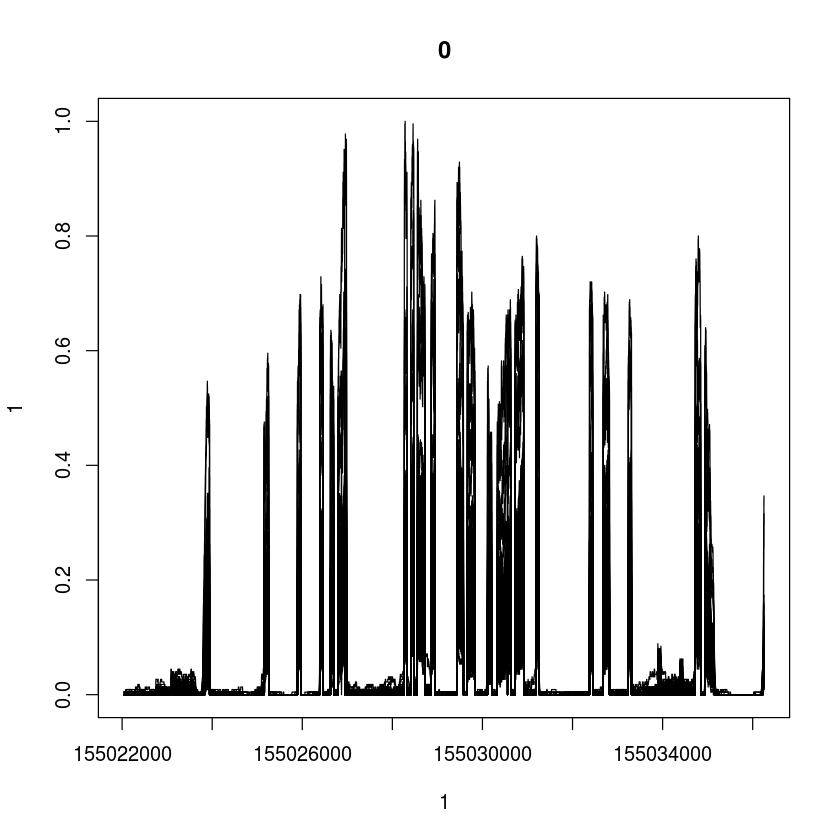

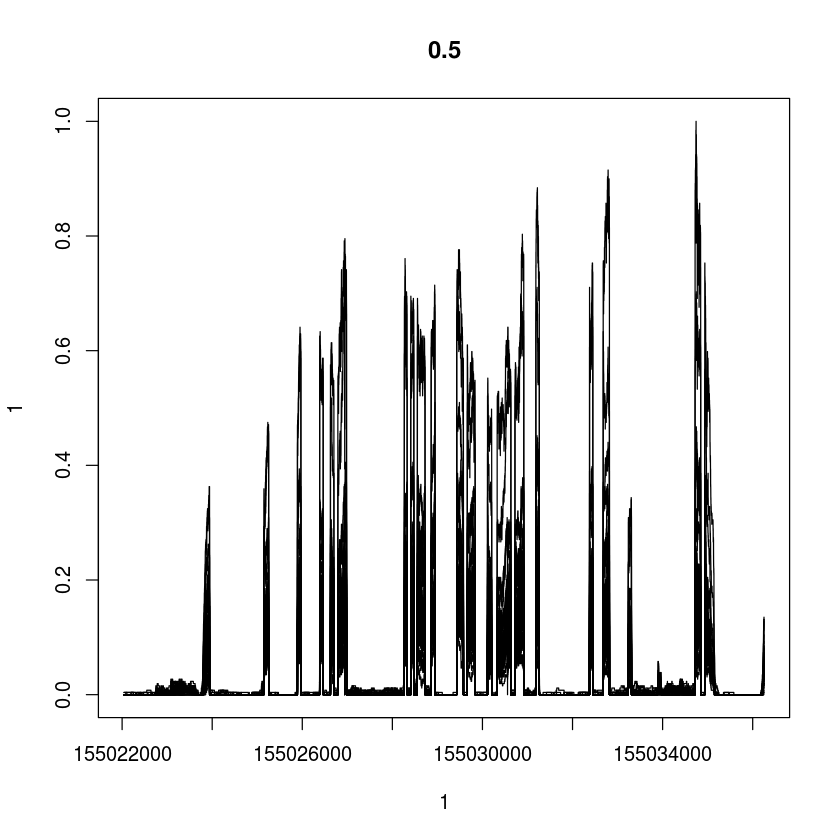

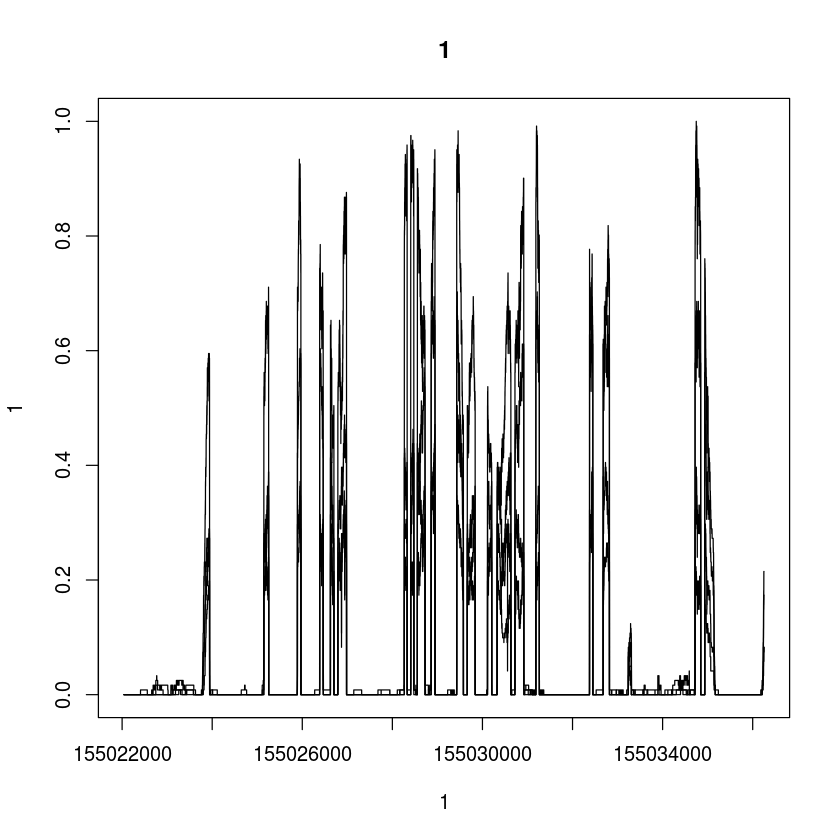

In [118]:
combine_by_genotype = function(gt, metadata, pileup_list)
{
    runs      = metadata[metadata$gt == gt, "run"]
    inlist    = pileup_list[runs]
    positions = inlist[[1]][,"pos"]
    
    out           = as.data.frame(matrix(0, nrow = length(positions), ncol = length(runs)))
    colnames(out) = runs
    
    for (run in runs)
    {
        out[,run] = inlist[[run]][,"cov"]
    }
    
    
    plot(1,1, type = "n", xlim = range(positions), ylim = c(0, 1), main = gt)
    #plot(1,1, type = "n", xlim = c(155032797,155033918), ylim = c(0, 1), main = gt)
    
    mymax = max(as.numeric(as.matrix(out)))
    
    for(run in runs)
    {
        lines(x = positions, y = out[,run] / mymax)
    }
 }

gt = 1

invisible(lapply(c(0, 0.5, 1), function(gt){combine_by_genotype(gt, metadata, pileup_list)}))




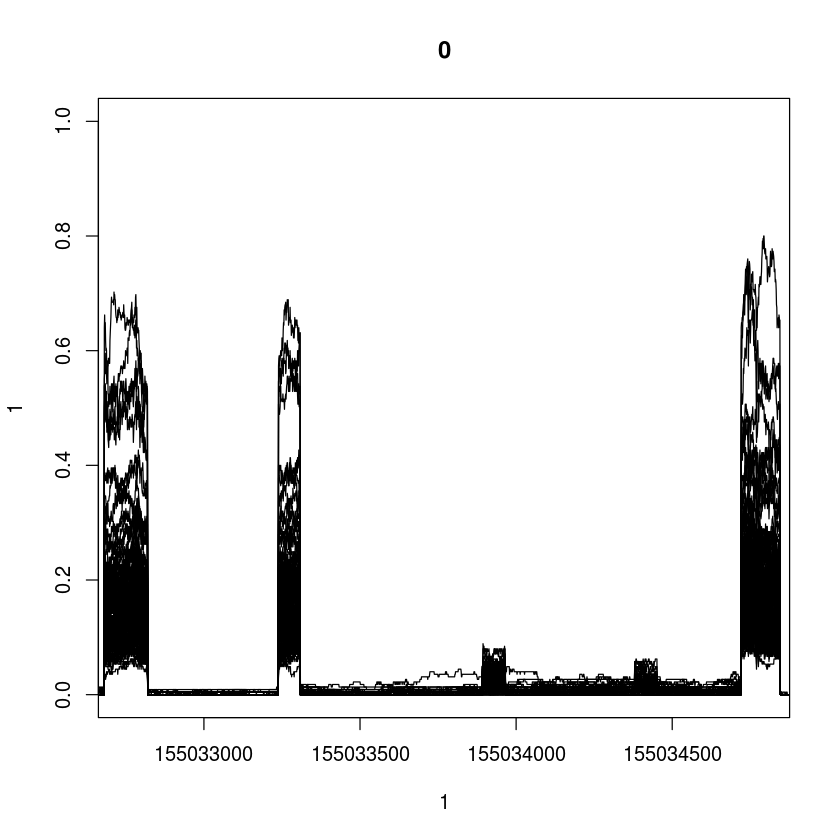

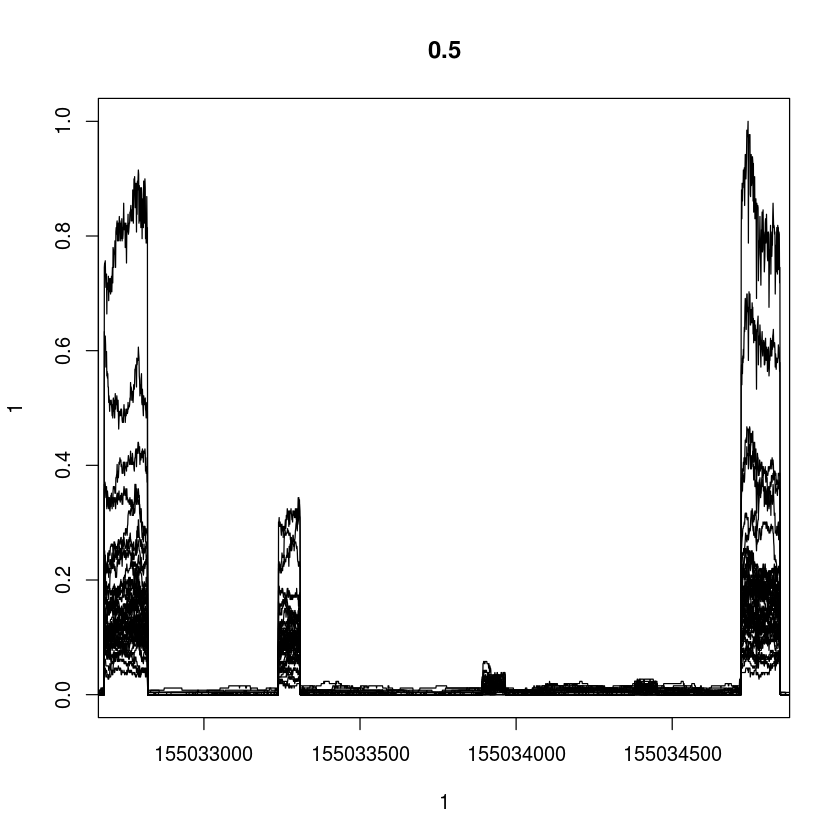

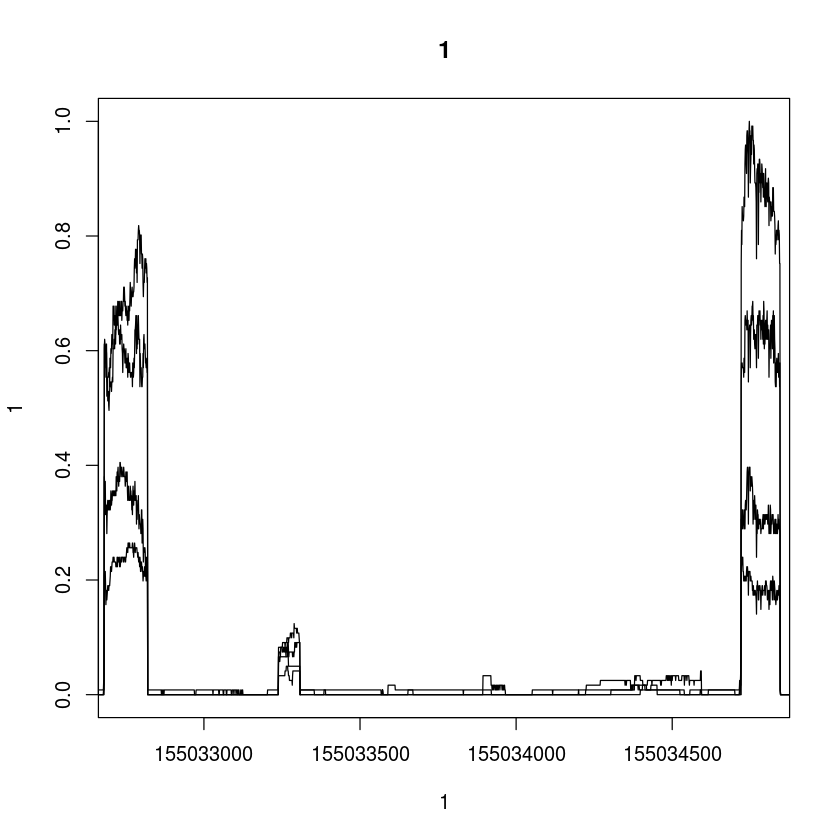

In [120]:
combine_by_genotype = function(gt, metadata, pileup_list)
{
    runs      = metadata[metadata$gt == gt, "run"]
    inlist    = pileup_list[runs]
    positions = inlist[[1]][,"pos"]
    
    out           = as.data.frame(matrix(0, nrow = length(positions), ncol = length(runs)))
    colnames(out) = runs
    
    for (run in runs)
    {
        out[,run] = inlist[[run]][,"cov"]
    }
    
    
    #plot(1,1, type = "n", xlim = range(positions), ylim = c(0, 1), main = gt)
    plot(1,1, type = "n", xlim = c(155032744,155034794), ylim = c(0, 1), main = gt)
    
    mymax = max(as.numeric(as.matrix(out)))
    
    for(run in runs)
    {
        lines(x = positions, y = out[,run] / mymax)
    }
 }

gt = 1

invisible(lapply(c(0, 0.5, 1), function(gt){combine_by_genotype(gt, metadata, pileup_list)}))




In [155]:
expall   = add_rownames(fread("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls/input/phenotypes/ipscore.isoform_percent_use.txt", sep = "\t", header = TRUE, data.table = FALSE))
geneinfo =              fread("/frazer01/reference/private/Gencode.v34lift37/isoform_info.txt"                                    , sep = "\t", header = TRUE, data.table = FALSE)
geneinfo = geneinfo[geneinfo$gene_id == gene_id,]
expall   = expall[geneinfo$transcript_id, metadata$run]

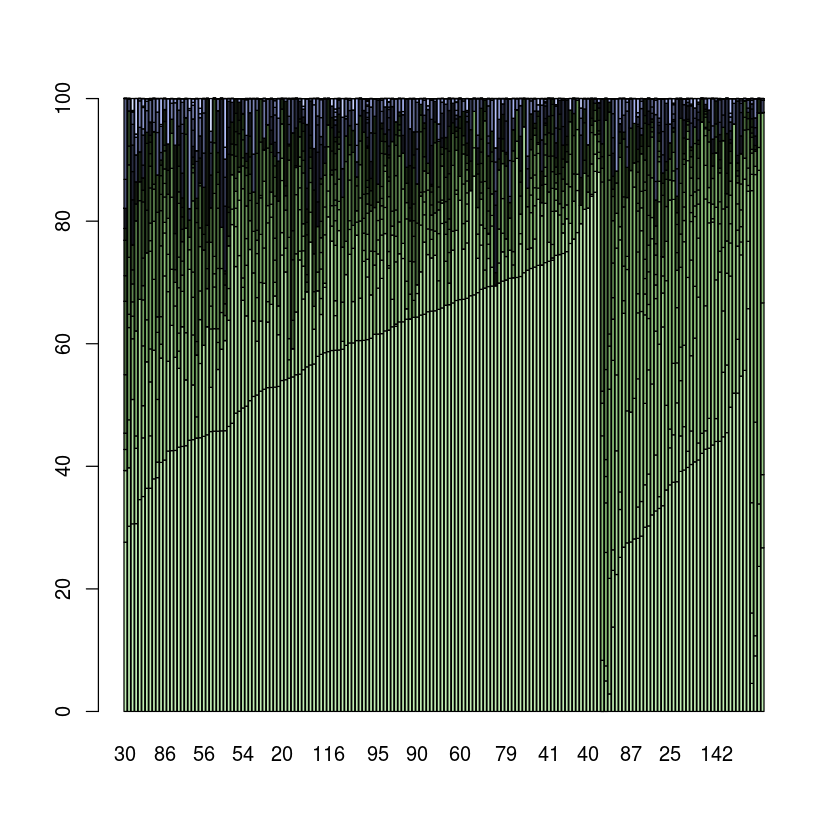

In [156]:
transcript2exp = data.frame(transcript_id = geneinfo$transcript_id, exp = as.numeric(rowMeans(expall)))
transcript2exp = transcript2exp[order(transcript2exp$exp, decreasing = TRUE),]
toplot         = merge(metadata[,c("gt", "run")], as.data.frame(t(as.matrix(expall))), by.x = "run", by.y = "row.names")
toplot         = toplot[order(toplot$gt, toplot[,transcript2exp[1, "transcript_id"]]), transcript2exp$transcript_id]

barplot(t(as.matrix(toplot)), col = diverge_hcl(palette = "Tofino", n = nrow(transcript2exp), rev = TRUE))

In [157]:
transcript2exp = data.frame(transcript_id = transcript_ids, exp = as.numeric(colMeans(metadata[,transcript_ids])))
transcript2exp = transcript2exp[order(transcript2exp$exp, decreasing = TRUE),]
toplot         = metadata[order(metadata$gt, metadata[,transcript2exp[1, "transcript_id"],]), transcript2exp$transcript_id]
toplot$other   = 100 - as.numeric(rowSums(toplot[,transcript_ids]))



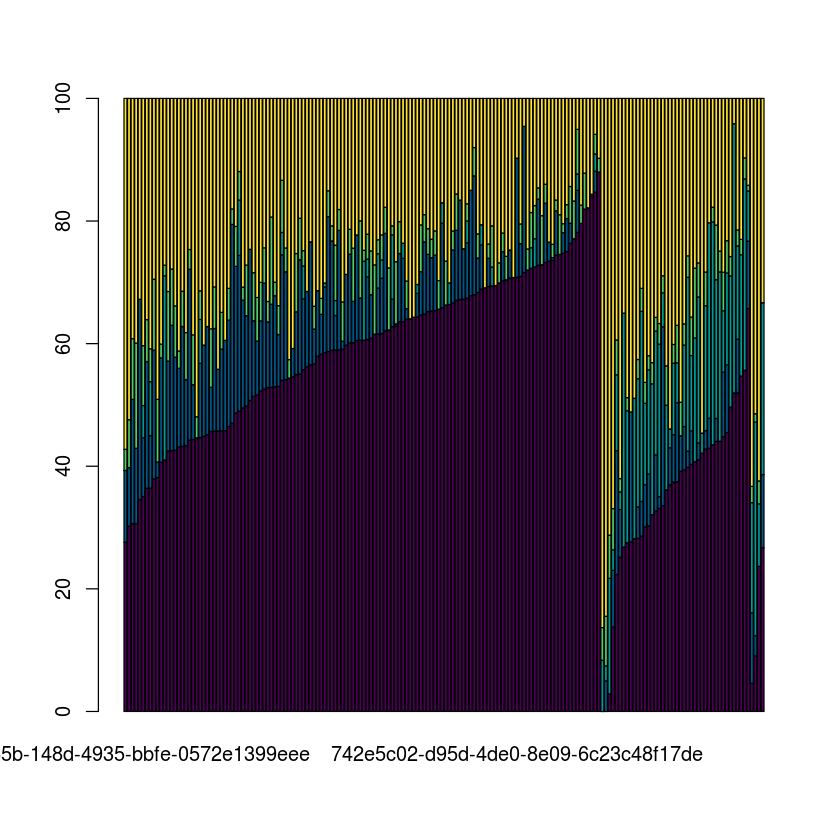

In [158]:
barplot(t(as.matrix(toplot)), col = sequential_hcl(palette = "Viridis", n = length(transcript_ids) + 1))

In [181]:
tonorm = exp_list$covariates[,c("run", "total_reads", "uniquely_mapped_reads_to_canonical_chromsomes")]
tonorm$norm_factor = tonorm$total_reads * tonorm$uniquely_mapped_reads_to_canonical_chromsomes / 100
tonorm$norm_factor = tonorm$norm_factor / mean(tonorm$norm_factor)

pileup_norm = lapply(names(pileup_list), function(run)
{
    x      = pileup_list[[run]]
    x$norm = x$cov / tonorm[tonorm$run == run, "norm_factor"]
    
    return(x[,c("pos", "ref", "cov", "norm", "n_ref", "n_alt")])
})
names(pileup_norm) = names(pileup_list)

In [198]:
pileup_by_gt = lapply(c(0, 0.5, 1), function(gt)
{
    runs      = metadata[metadata$gt == gt, "run"]
    inlist    = pileup_norm[runs]
    positions = inlist[[1]][,"pos"]
    
    out           = as.data.frame(matrix(0, nrow = length(positions), ncol = length(runs)))
    colnames(out) = runs
    
    for (run in runs)
    {
        out[,run] = inlist[[run]][,"norm"]
    }
    
    return(data.frame(pos    = positions,
                      mean   = rowMeans(out),
                      median = unlist(apply(out, 1, median)),
                      min    = unlist(apply(out, 1, min   )),
                      max    = unlist(apply(out, 1, max   )),
                      q1     = unlist(apply(out, 1, function(x){quantile(x, probs = 0.25)})),
                      q3     = unlist(apply(out, 1, function(x){quantile(x, probs = 0.75)}))
                     ))
})

names(pileup_by_gt) = c("G/G", "G/A", "A/A")

In [199]:
to_figure = list(transcript2exp = transcript2exp,
                 info           = geneinfo[geneinfo$transcript_id %in% transcript_ids,],
                 metadata       = metadata,
                 tonorm         = tonorm,
                 pileup         = pileup_norm,
                 pileup_by_gt   = pileup_by_gt
                )

saveRDS(to_figure, "pipeline/eqtl.3.adam15/to_figure.rds")

In [160]:
str(transcript2exp)

geneinfo[geneinfo$transcript_id %in% transcript_ids,]

'data.frame':	4 obs. of  2 variables:
 $ transcript_id: chr  "ENST00000271836.10_1" "ENST00000464824.2_1" "ENST00000474709.5_1" "ENST00000525020.1_1"
 $ exp          : num  52.6 8.6 5.32 4.05


,chrom,start,end,strand,gene_id,gene_name,gene_type,transcript_id,transcript_type
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
12913,chr1,155023782,155035251,+,ENSG00000143537.13_4,ADAM15,protein_coding,ENST00000271836.10_1,protein_coding
12924,chr1,155028572,155029703,+,ENSG00000143537.13_4,ADAM15,protein_coding,ENST00000525020.1_1,retained_intron
12927,chr1,155031186,155035251,+,ENSG00000143537.13_4,ADAM15,protein_coding,ENST00000474709.5_1,processed_transcript
12930,chr1,155034637,155035251,+,ENSG00000143537.13_4,ADAM15,protein_coding,ENST00000464824.2_1,retained_intron


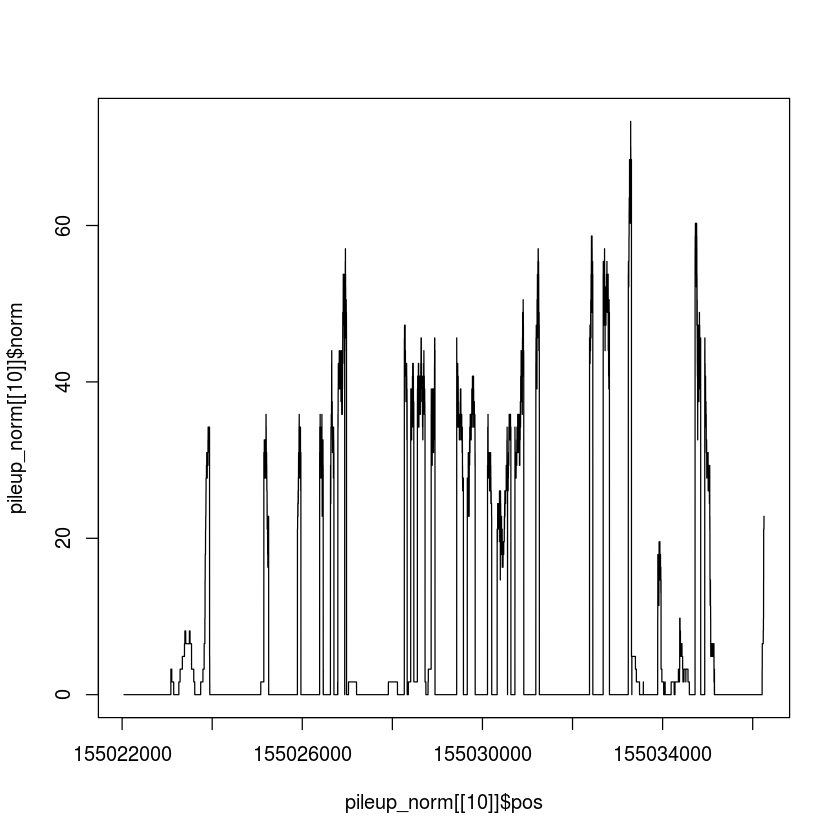

In [186]:


plot(pileup_norm[[10]]$pos, pileup_norm[[10]]$norm, type = "l")

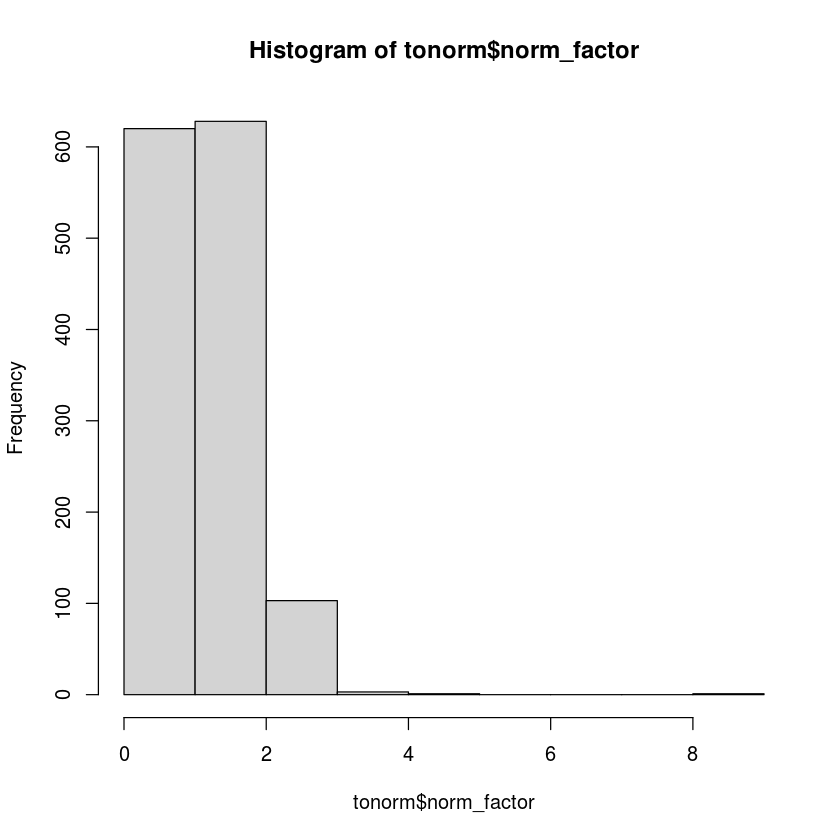

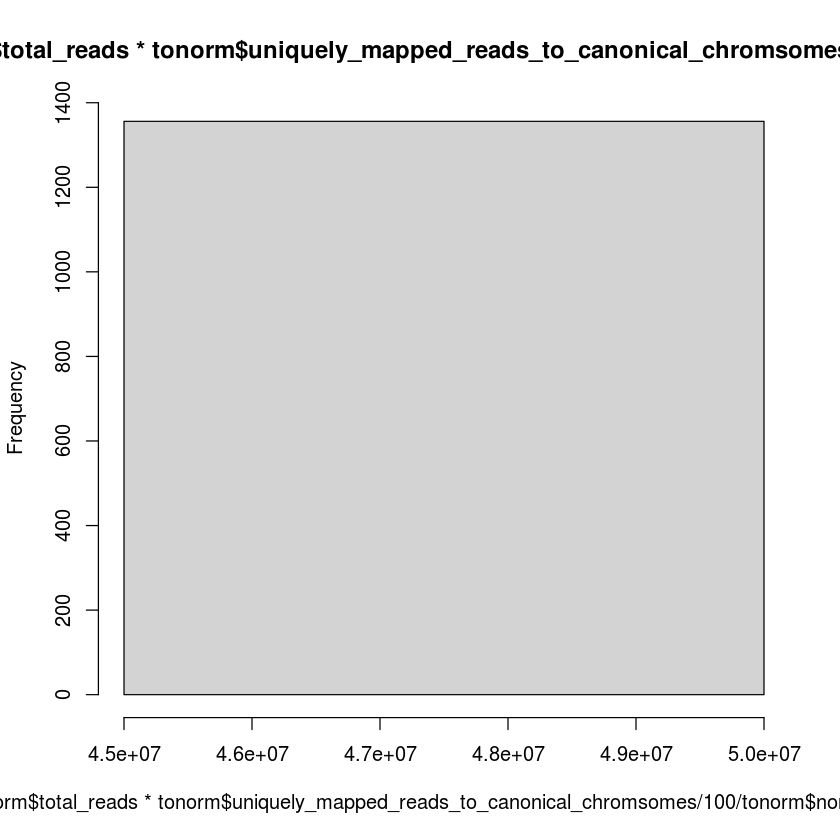

In [174]:
hist(tonorm$norm_factor)
hist(tonorm$total_reads * tonorm$uniquely_mapped_reads_to_canonical_chromsomes / 100 / tonorm$norm_factor)